## **"Titulo: Análisis de Características Clínicas y Creación de un Modelo Predictivo para Hospitalización en Pacientes Post Biopsia Prostática"**


### **1. Premisa**
Nuestro cliente desea saber las características más importantes que tienen los pacientes de cierto tipo de enfermedad que terminan en hospitalización.

Fue definido como caso aquel paciente que fue sometido a biopsia prostática, y que en un periodo máximo de 30 días posteriores al procedimiento presentó fiebre, infección urinaria o sepsis, requiriendo manejo médico ambulatorio u hospitalizado para la resolución de la complicación.

Y como control al paciente que fue sometido a biopsia prostática y que no presentó complicaciones infecciosas en el período de 30 días posteriores al procedimiento.

Para ello, nuestro departamento de datos ha recopilado Antecedentes del paciente, Morbilidad asociada al paciente y Antecedentes relacionados con la toma de la biopsia y Complicaciones infecciosas. En la siguiente tabla, se encuentra un diccionario de datos asociado:

![image](https://user-images.githubusercontent.com/118769777/220240501-8c21461d-2de5-495b-954e-10fb9bf38014.png)

El departamento de datos advierte que hay algunos problemas de calidad de datos en la información suministrada

Recuerden que nuestro cliente desea saber las características más importantes que tienen los pacientes de cierto tipo de enfermedad que terminan en hospitalización y crear un modelo predictivo de clasificación para la variable objetivo: Hospitalización.



### **2. Preparación de datos**
Carga de la base de datos y análisis básico del dataframe para determinar la integridad del mismo


In [72]:
# Librerías utilizadas en el documento
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from scipy.stats import chi2_contingency

df = pd.read_excel('BBDD_Hospitalización.xlsx')
info_dataframe = df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570 entries, 0 to 569
Data columns (total 20 columns):
 #   Column                                                                     Non-Null Count  Dtype  
---  ------                                                                     --------------  -----  
 0   EDAD                                                                       568 non-null    float64
 1   DIABETES                                                                   568 non-null    object 
 2   HOSPITALIZACIÓN ULTIMO MES                                                 568 non-null    object 
 3   PSA                                                                        564 non-null    float64
 4   BIOPSIAS PREVIAS                                                           566 non-null    object 
 5   VOLUMEN PROSTATICO                                                         567 non-null    object 
 6   ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS                   

d:\Proyectos\Data Science\Hospitales ML\venv\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [73]:
descripcion_dataframe = df.describe(include='all')
print(descripcion_dataframe)

              EDAD DIABETES HOSPITALIZACIÓN ULTIMO MES         PSA  \
count   568.000000      568                        568  564.000000   
unique         NaN        2                          2         NaN   
top            NaN       NO                         NO         NaN   
freq           NaN      505                        563         NaN   
mean     63.882042      NaN                        NaN   13.271401   
std       9.281517      NaN                        NaN   15.668966   
min      39.000000      NaN                        NaN    0.600000   
25%      59.000000      NaN                        NaN    5.600000   
50%      64.000000      NaN                        NaN    8.000000   
75%      69.000000      NaN                        NaN   15.000000   
max     151.000000      NaN                        NaN  100.000000   

       BIOPSIAS PREVIAS VOLUMEN PROSTATICO  \
count               566                567   
unique                2                  2   
top                  

In [74]:
# Revisión de datos nulos
nulos_dataframe = df.isnull().sum()
display(nulos_dataframe)

EDAD                                                                          2
DIABETES                                                                      2
HOSPITALIZACIÓN ULTIMO MES                                                    2
PSA                                                                           6
BIOPSIAS PREVIAS                                                              4
VOLUMEN PROSTATICO                                                            3
ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS                                       2
NUMERO DE MUESTRAS TOMADAS                                                    2
CUP                                                                           3
ENF. CRONICA PULMONAR OBSTRUCTIVA                                             4
BIOPSIA                                                                       2
NUMERO DE DIAS POST BIOPSIA EN QUE SE PRESENTA LA COMPLICACIÓN INFECCIOSA     2
FIEBRE                                  

### **3. Limpieza de los datos**

#### - 3.1 Eliminación de Parámetros innecesarios o redundantes

In [75]:
# Las siguientes columnas son parámetros de complicaciones infeccionas los cuales no queremos meter al modelo
# ya que al presentarlos deducimos que ya esta la complicación presente en el paciente
# vamos a retirarlos para encontrar pro-activamente los pacientes con mayor probabilidad de presentar la complicación
eliminar_cols = [ 'NUMERO DE DIAS POST BIOPSIA EN QUE SE PRESENTA LA COMPLICACIÓN INFECCIOSA','FIEBRE','ITU','TIPO DE CULTIVO','AGENTE AISLADO','PATRON DE RESISTENCIA','DIAS HOSPITALIZACION MQ','DIAS HOSPITALIZACIÓN UPC']
df.drop(eliminar_cols,axis=1,inplace=True)
df.columns


Index(['EDAD', 'DIABETES', 'HOSPITALIZACIÓN ULTIMO MES', 'PSA',
       'BIOPSIAS PREVIAS', 'VOLUMEN PROSTATICO',
       'ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS', 'NUMERO DE MUESTRAS TOMADAS',
       'CUP', 'ENF. CRONICA PULMONAR OBSTRUCTIVA', 'BIOPSIA',
       'HOSPITALIZACION'],
      dtype='object')

#### - 3.2 Tratamiento de los datos nulos
**3.2.1**
Primero encontramos 3 valores nulos en la variable **objetivo ('HOSPITALIZACION')** ademas de 2 filas vacias, por lo que se entiende que no se pueden inputar 
de una manera segura estos valores, por lo que se decide a retirarlos

In [76]:
print(df.shape[0])
df = df.dropna(subset=['HOSPITALIZACION'])
print(df.shape[0])

570
565


**3.2.2** Para las varibles numericas vamos a imputar por la media

In [77]:
# Media aritmética del parámetro
mean_psa = round(df.PSA.mean(),2)
df.PSA.fillna(mean_psa,inplace=True)

**3.2.3** Para las varibles booleanas vamos a imputar por la moda de la columna

In [78]:
# variables categóricas
col_bool_null = ['VOLUMEN PROSTATICO','CUP','BIOPSIAS PREVIAS','ENF. CRONICA PULMONAR OBSTRUCTIVA']

for col in col_bool_null:
    moda_col = df[col].value_counts().idxmax()
    df[col].fillna(moda_col,inplace=True)

df.isnull().sum()

EDAD                                       0
DIABETES                                   0
HOSPITALIZACIÓN ULTIMO MES                 0
PSA                                        0
BIOPSIAS PREVIAS                           0
VOLUMEN PROSTATICO                         0
ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS    0
NUMERO DE MUESTRAS TOMADAS                 0
CUP                                        0
ENF. CRONICA PULMONAR OBSTRUCTIVA          0
BIOPSIA                                    0
HOSPITALIZACION                            0
dtype: int64

**3.2.4** Normalizacion de columnas categoricas

In [79]:
# remplazamos los valores parecidos para unificar la columna categórica
rep = {'FLUOROQUINOLONA_AMINOGLICÓSIDO':'FLUOROQUINOLONA_AMINOGLICOSIDO'}
df['ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS'] = df['ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS'].replace(rep)

df['BIOPSIA'] = df['BIOPSIA'].str.strip()

df['ENF. CRONICA PULMONAR OBSTRUCTIVA'] = df['ENF. CRONICA PULMONAR OBSTRUCTIVA'].replace('SI, EPOC','SI')
df['ENF. CRONICA PULMONAR OBSTRUCTIVA'] = df['ENF. CRONICA PULMONAR OBSTRUCTIVA'].replace('SI, ASMA','SI')

#### - 3.3 Tratamiento de Outliers

**3.3.1** Revision la distribución estadística para el caso de las variables numéricas. 
Utilizaremos los histogramas para esta revision 

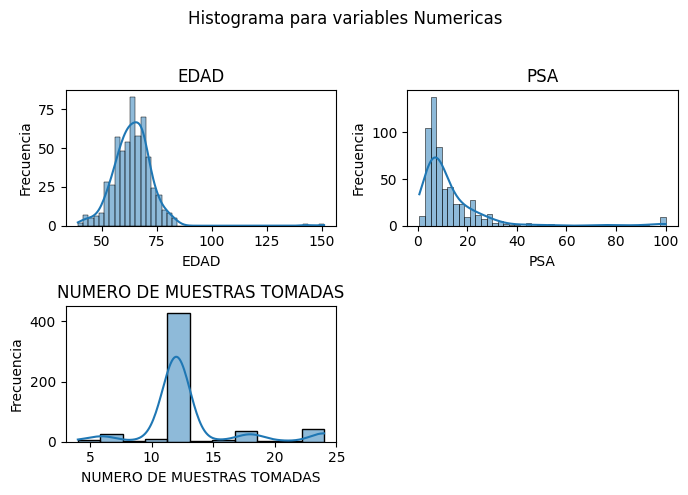

In [80]:
# Función para hacer un plot de las variables numéricas
def plot_histograms(df):
    numerical_features = ['EDAD', 'PSA', 'NUMERO DE MUESTRAS TOMADAS']
    fig, axes = plt.subplots(2, 2, figsize=(7, 5))
    fig.suptitle('Histograma para variables Numericas')
    axes = axes.flatten()
    for i, feature in enumerate(numerical_features):
        sns.histplot(df[feature], kde=True, ax=axes[i])
        axes[i].set_title(feature)
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frecuencia')

    # Remover el ultimo plot que no es utilizado
    fig.delaxes(axes[-1])
    plt.tight_layout(rect=[0, 0, 1, 0.96])

# Plot de histogramas
plot_histograms(df)
plt.show()

In [81]:
# Se imputaron con la media los datos atípicos de la edad con la media de los datos restantes
media_menor_100 = df[df["EDAD"] < 100]["EDAD"].mean()
print(round(media_menor_100))
df.loc[df["EDAD"] > 100, "EDAD"] = media_menor_100

64


3.3.2 Revision la distribución estadística para el caso de las variables Categoricas. 

C:\Users\octav\AppData\Local\Temp\ipykernel_17628\4189308050.py:16: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[10, 10, -5, 0.8])


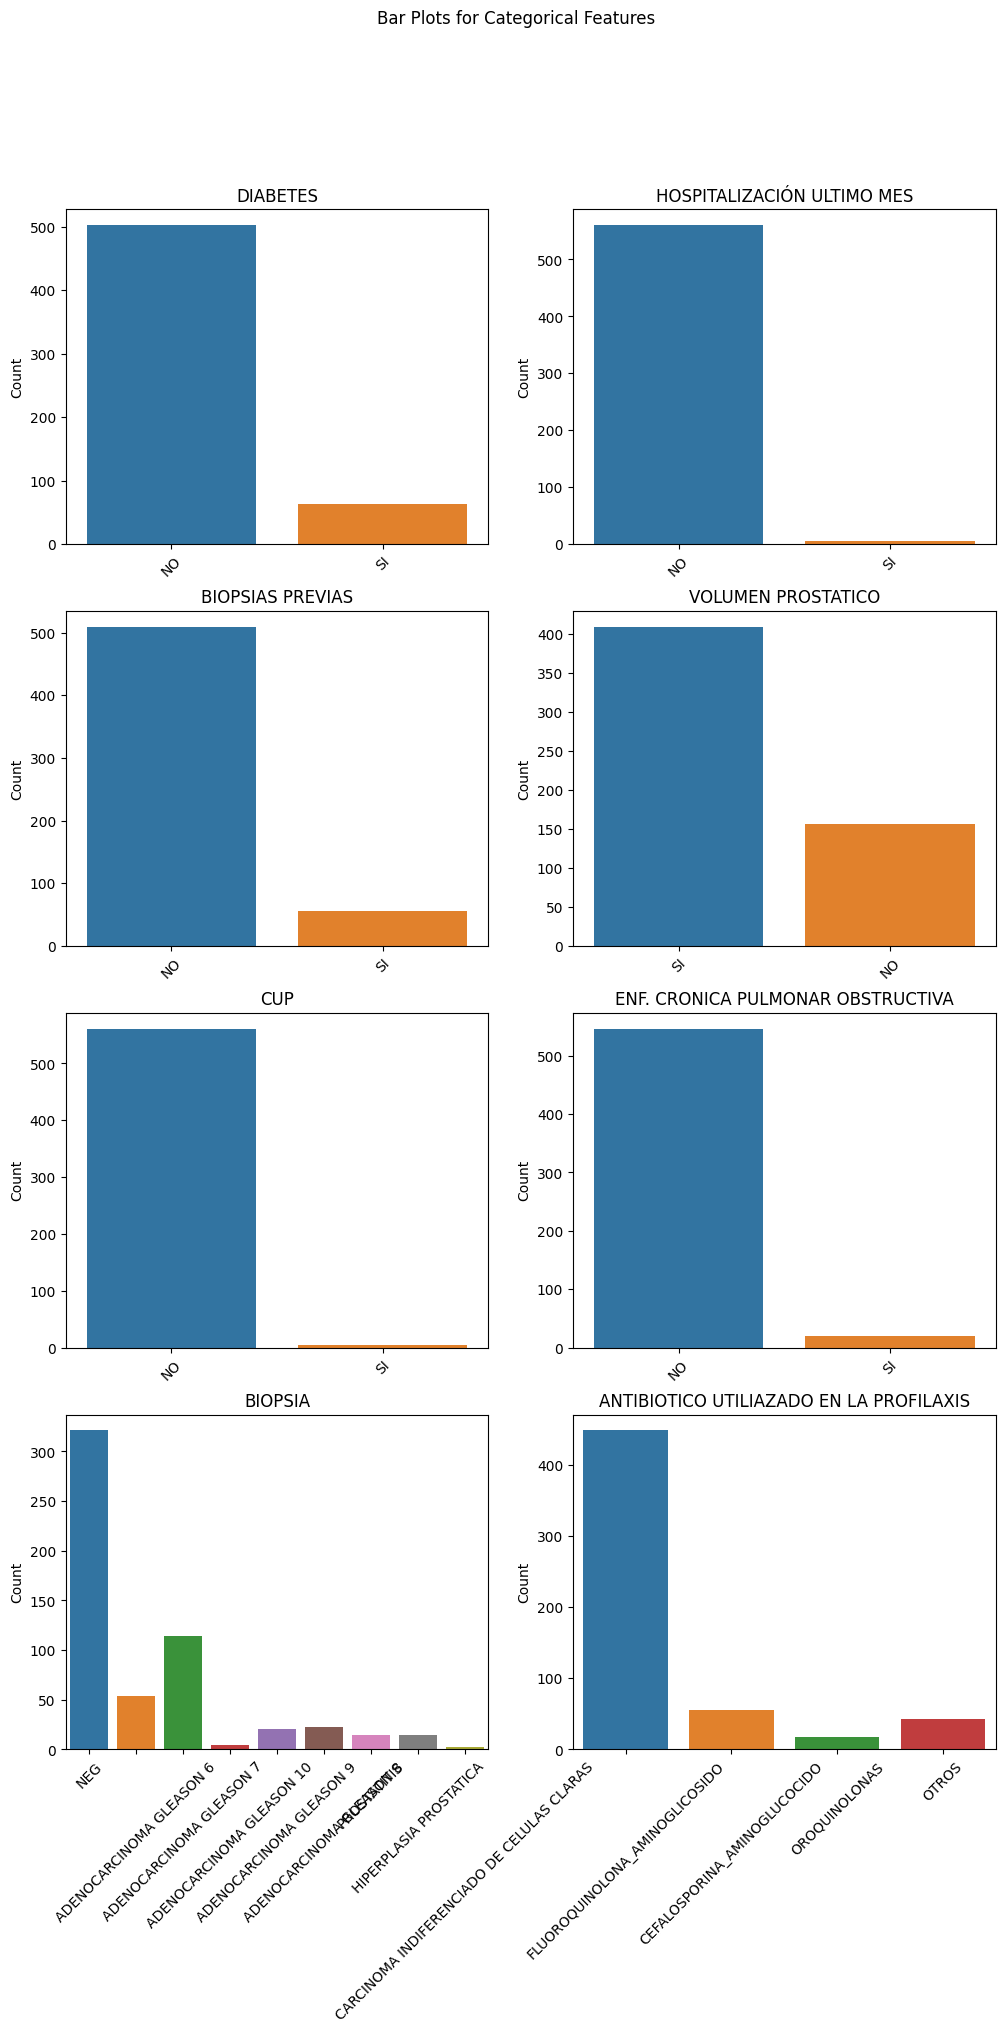

In [82]:
 # Function to plot bar plots for categorical features
def plot_bar_plots(df):
    categorical_features = ['DIABETES', 'HOSPITALIZACIÓN ULTIMO MES', 'BIOPSIAS PREVIAS',
                            'VOLUMEN PROSTATICO','CUP', 
                            'ENF. CRONICA PULMONAR OBSTRUCTIVA','BIOPSIA' , 'ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS']
                            
    fig, axes = plt.subplots(4, 2, figsize=(12, 20))
    fig.suptitle('Bar Plots for Categorical Features')
    axes = axes.flatten()
    for i, feature in enumerate(categorical_features):
        sns.countplot(x=df[feature], ax=axes[i])
        axes[i].set_title(feature)
        axes[i].set_xlabel(None)
        axes[i].set_ylabel('Count')
        axes[i].tick_params(axis='x', rotation=45)
    plt.tight_layout(rect=[10, 10, -5, 0.8])

# Plotting the bar plots
plot_bar_plots(df)
plt.show()



## 4. Análisis Exploratorio básico

### 4.1 Buscando correlaciones con las variables numéricas

d:\Proyectos\Data Science\Hospitales ML\venv\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


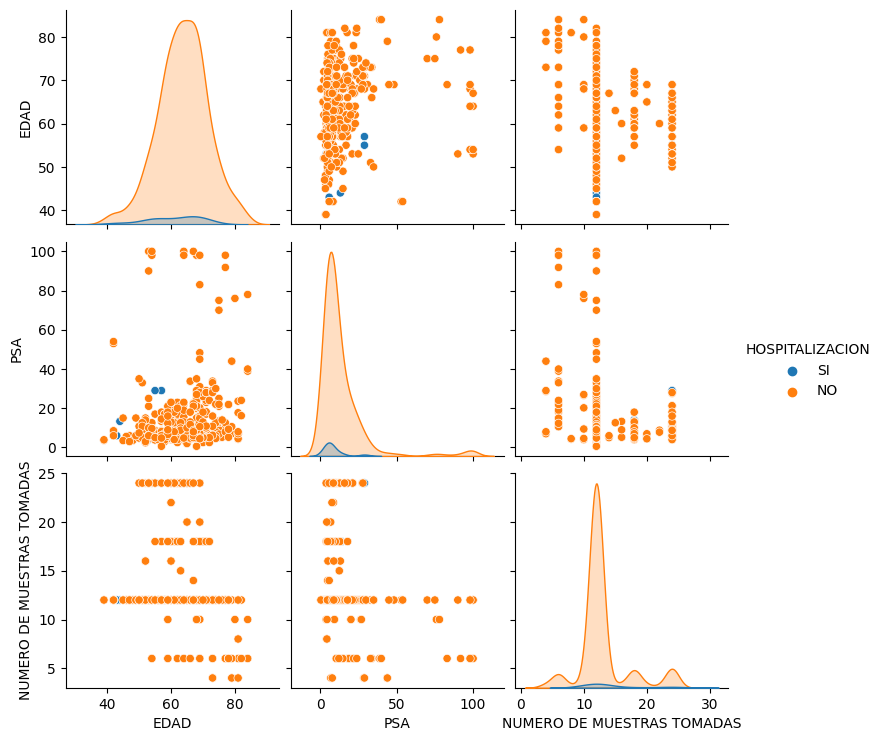

In [83]:
sns.pairplot(df, hue = 'HOSPITALIZACION')
plt.show()

### 4.2 Creamos una matriz de correlaciones para las variables numéricas

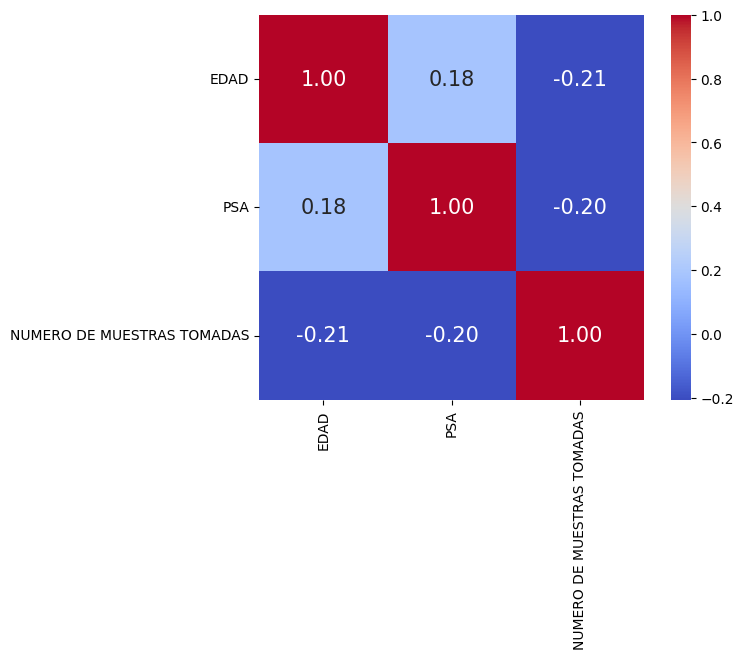

In [84]:
num = ['EDAD', 'PSA', 'NUMERO DE MUESTRAS TOMADAS']
corr = df[num].corr()
plt.figure(figsize=(7,5))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= num,
           yticklabels= num,
           cmap= 'coolwarm')
plt.show()

### 4.3 Matriz de corelaciones para las variables Categoricas

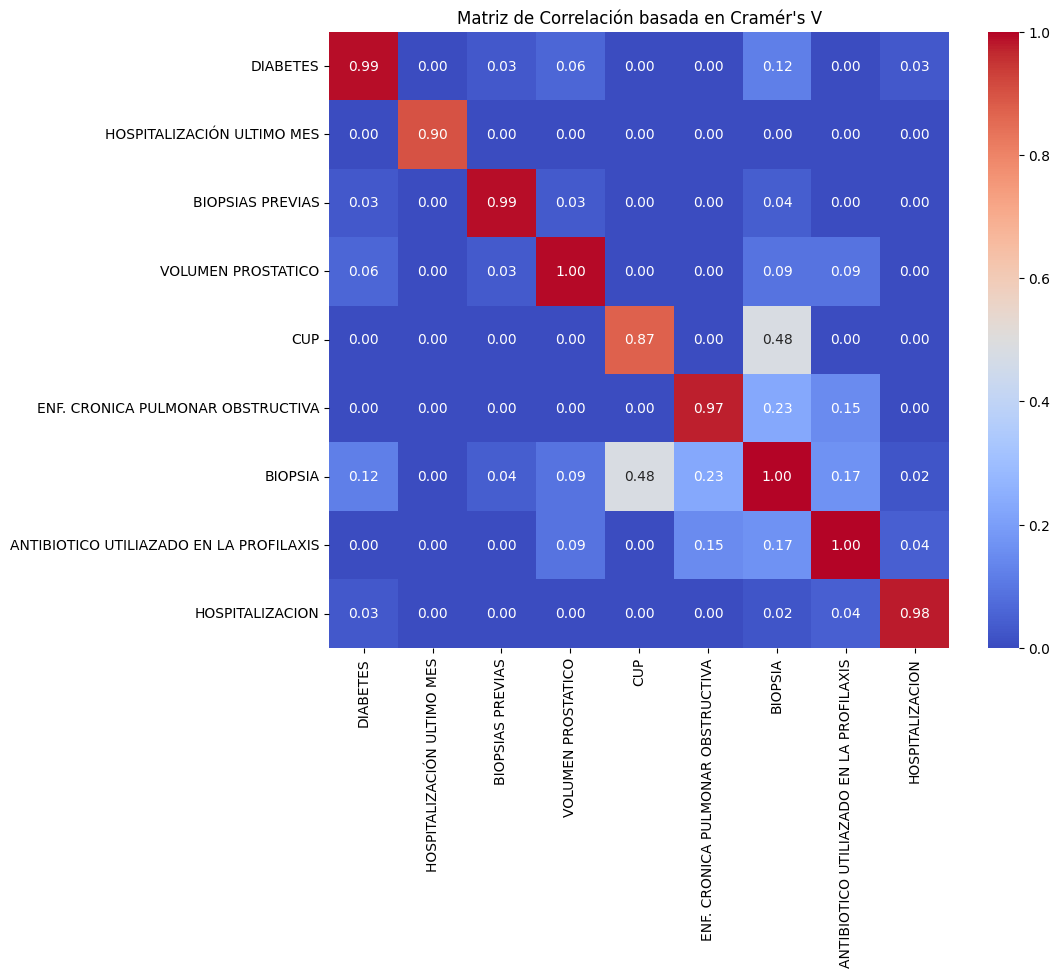

In [85]:
def cramers_v(table):
    chi2 = chi2_contingency(table)[0]
    n = table.sum().sum()
    phi2 = chi2 / n
    r, k = table.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    r_corr = r - ((r - 1)**2) / (n - 1)
    k_corr = k - ((k - 1)**2) / (n - 1)
    return (phi2corr / min((k_corr - 1), (r_corr - 1)))**0.5

# Columnas binarias y categóricas
columnas = ['DIABETES', 'HOSPITALIZACIÓN ULTIMO MES', 'BIOPSIAS PREVIAS',
            'VOLUMEN PROSTATICO','CUP', 'ENF. CRONICA PULMONAR OBSTRUCTIVA',
            'BIOPSIA' , 'ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS','HOSPITALIZACION']

# Crear una matriz de correlación utilizando el coeficiente de Cramér's V
correlation_matrix = pd.DataFrame(index=columnas, columns=columnas)
for col1 in columnas:
    for col2 in columnas:
        cross_tab = pd.crosstab(df[col1], df[col2])
        correlation_matrix.loc[col1, col2] = cramers_v(cross_tab)

# Convertir los valores a números y mostrar la matriz de correlación como un heatmap
correlation_matrix = correlation_matrix.apply(pd.to_numeric)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación basada en Cramér's V")
plt.show()

## 5 Unificacion de Variables

### 5.1 Cambio de tipo categorico a tipo binario

In [86]:
reemplazos = {"NO": 0, "SI": 1}
columnas_a_reemplazar  = ['DIABETES', 'HOSPITALIZACIÓN ULTIMO MES', 'BIOPSIAS PREVIAS',
            'VOLUMEN PROSTATICO','CUP', 'ENF. CRONICA PULMONAR OBSTRUCTIVA','HOSPITALIZACION']

df[columnas_a_reemplazar] = df[columnas_a_reemplazar].replace(reemplazos)
df.head(3)

EDAD  DIABETES  HOSPITALIZACIÓN ULTIMO MES   PSA  BIOPSIAS PREVIAS  \
0  53.0         0                           0   4.0                 0   
1  56.0         0                           0   7.7                 0   
2  57.0         0                           0  29.0                 1   

   VOLUMEN PROSTATICO ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS  \
0                   1          FLUOROQUINOLONA_AMINOGLICOSIDO   
1                   1          FLUOROQUINOLONA_AMINOGLICOSIDO   
2                   1          FLUOROQUINOLONA_AMINOGLICOSIDO   

   NUMERO DE MUESTRAS TOMADAS  CUP  ENF. CRONICA PULMONAR OBSTRUCTIVA BIOPSIA  \
0                        12.0    0                                  0     NEG   
1                        12.0    0                                  0     NEG   
2                        24.0    0                                  0     NEG   

   HOSPITALIZACION  
0                1  
1                1  
2                1

### 5.2 Cambio de columnas categoricas a columnas dummy


In [87]:
# crear dummies

columna_categorica = "ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS"
df_dummies = pd.get_dummies(df[columna_categorica], prefix='ANTIBIOTICO USADO')
df_dum = pd.concat([df, df_dummies], axis=1)

columna_categorica2 = "BIOPSIA"
df_dummies2 = pd.get_dummies(df[columna_categorica2], prefix='BIOPSIA')
df_dum = pd.concat([df_dum, df_dummies2], axis=1)

df_dum.drop('ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS',axis=1,inplace=True)
df_dum.drop('BIOPSIA',axis=1,inplace=True)

df_dum

EDAD  DIABETES  HOSPITALIZACIÓN ULTIMO MES    PSA  BIOPSIAS PREVIAS  \
0    53.0         0                           0   4.00                 0   
1    56.0         0                           0   7.70                 0   
2    57.0         0                           0  29.00                 1   
3    56.0         0                           0   7.00                 0   
4    55.0         0                           0  29.00                 1   
..    ...       ...                         ...    ...               ...   
563  67.0         0                           0   6.00                 0   
564  64.0         0                           0   4.80                 0   
565  69.0         0                           0   4.43                 0   
566  67.0         0                           0   8.00                 0   
567  59.0         0                           0   9.00                 1   

     VOLUMEN PROSTATICO  NUMERO DE MUESTRAS TOMADAS  CUP  \
0                     1                        12.0    0   
1                     1                        12.0    0   
2                     1                        24.0    0   
3                     1                        12.0    0   
4                     1                        24.0    0   
..                  ...                         ...  ...   
563                   1                        12.0    0   
564                   1                        12.0    0   
565                   1                        20.0    0   
566                   1                        12.0    0   
567                   1                        12.0    0   

     ENF. CRONICA PULMONAR OBSTRUCTIVA  HOSPITALIZACION  ...  \
0                                    0                1  ...   
1                                    0                1  ...   
2                                    0                1  ...   
3                                    0                1  ...   
4                                    0                1  ...   
..                                 ...              ...  ...   
563                                  0                0  ...   
564                                  0                0  ...   
565                                  0                0  ...   
566                                  0                0  ...   
567                                  0                0  ...   

     ANTIBIOTICO USADO_OTROS  BIOPSIA_ADENOCARCINOMA GLEASON 10  \
0                      False                              False   
1                      False                              False   
2                      False                              False   
3                      False                              False   
4                      False                              False   
..                       ...                                ...   
563                    False                              False   
564                     True                              False   
565                    False                              False   
566                    False                              False   
567                    False                              False   

     BIOPSIA_ADENOCARCINOMA GLEASON 6  BIOPSIA_ADENOCARCINOMA GLEASON 7  \
0                               False                             False   
1                               False                             False   
2                               False                             False   
3                               False                             False   
4                               False                             False   
..                                ...                               ...   
563                              True                             False   
564                             False                              True   
565                             False                             False   
566                             False          

### 5.3 Balanceamos el Df con un oversampleo de los valores de hospitalizacion positivos


In [88]:
# balancear multiplicando los valores

# Separar las características y la variable objetivo
X = df_dum.drop('HOSPITALIZACION', axis=1)  # Características
y = df_dum['HOSPITALIZACION']  # Variable objetivo

# Crear el objeto de oversampling
oversampler = RandomOverSampler(sampling_strategy='minority')

# Aplicar el oversampling a las características y la variable objetivo
X_oversampled, y_oversampled = oversampler.fit_resample(X, y)

# Crear un nuevo DataFrame con las características oversampleadas y la variable objetivo
df_oversampled = pd.concat([X_oversampled, y_oversampled], axis=1)

df_oversampled.shape[0]

1082

### 5.4 Creamos una matriz de corelacion con el DF oversampleado y con los valores en binario

In [89]:
corr = df_oversampled.corr()
plt.figure(figsize=(100,100))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 45},
           xticklabels= df_oversampled.columns,
           yticklabels= df_oversampled.columns,
           cmap= 'coolwarm')
plt.xticks(rotation=45, ha='right',fontsize=45)
plt.yticks(fontsize=45)


plt.show()

## 6 Exportar DataFrame
Exportamos los datos para tener el archivo listo y limpio para el modelamiento.

In [90]:
df_oversampled.to_csv('revision.csv',index=False)


## 7. Modelamiento

Una vez preparados los datos, se procederá con el modelamiento.Con objetivo de clasificar a un paciente como hospitalizado o no hospitalizado, teniendo en cuenta el data set que contiene información referente a antecedentes del paciente, morbilidad asociada al paciente y antecedentes relacionados con la toma de la biopsia y complicaciones infecciosas.

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [92]:
df = pd.read_csv('revision.csv')
df.head(3)

EDAD  DIABETES  HOSPITALIZACIÓN ULTIMO MES   PSA  BIOPSIAS PREVIAS  \
0  53.0         0                           0   4.0                 0   
1  56.0         0                           0   7.7                 0   
2  57.0         0                           0  29.0                 1   

   VOLUMEN PROSTATICO  NUMERO DE MUESTRAS TOMADAS  CUP  \
0                   1                        12.0    0   
1                   1                        12.0    0   
2                   1                        24.0    0   

   ENF. CRONICA PULMONAR OBSTRUCTIVA  \
0                                  0   
1                                  0   
2                                  0   

   ANTIBIOTICO USADO_CEFALOSPORINA_AMINOGLUCOCIDO  ...  \
0                                           False  ...   
1                                           False  ...   
2                                           False  ...   

   BIOPSIA_ADENOCARCINOMA GLEASON 10  BIOPSIA_ADENOCARCINOMA GLEASON 6  \
0                              False                             False   
1                              False                             False   
2                              False                             False   

   BIOPSIA_ADENOCARCINOMA GLEASON 7  BIOPSIA_ADENOCARCINOMA GLEASON 8  \
0                             False                             False   
1                             False                             False   
2                             False                             False   

   BIOPSIA_ADENOCARCINOMA GLEASON 9  \
0                             False   
1                             False   
2                             False   

   BIOPSIA_CARCINOMA INDIFERENCIADO DE CELULAS CLARAS  \
0                                              False    
1                                              False    
2                                              False    

   BIOPSIA_HIPERPLASIA PROSTATICA  BIOPSIA_NEG  BIOPSIA_PROSTATITIS  \
0                           False         True                False   
1                           False         True                False   
2                           False         True                False   

   HOSPITALIZACION  
0                1  
1                1  
2                1  

[3 rows x 23 columns]

## 8. Modelo Tree

Para la primer prueba vamos a usar un model tipo tree 

In [ ]:
from sklearn.tree import DecisionTreeClassifier

### 8.1 Configuración inicial

#### 8.1.1 Dividimos el dataframe para crear las variables del modelo 'X' y la variable a predecir 'y'

In [93]:
# Seleccionamos las variables predictoras X y la variable a predecir

X = df.drop(['HOSPITALIZACION'],axis=1)
y = df['HOSPITALIZACION']

# transformación de los datos para ser usados en los modelos
X = X.values

#### 8.1.2 Separar el modelo en el Train y en el test



In [94]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

#### 8.1.3 Revisamos la cantidad de resultados positivos y negativos en la divisiones de train y test respectivamente.

In [95]:
print('Proporción de etiquetas en set de entrenamiento:', y_train.sum()/y_train.count())
print('Proporción de etiquetas en set de testeo:', y_test.sum()/y_test.count())

Proporción de etiquetas en set de entrenamiento: 0.4797687861271676
Proporción de etiquetas en set de testeo: 0.5806451612903226


### 8.2 Selección de Hiperparámetros

Haremos un proceso iterativo para encontrar el mejor hyperparametro para el modelo tree

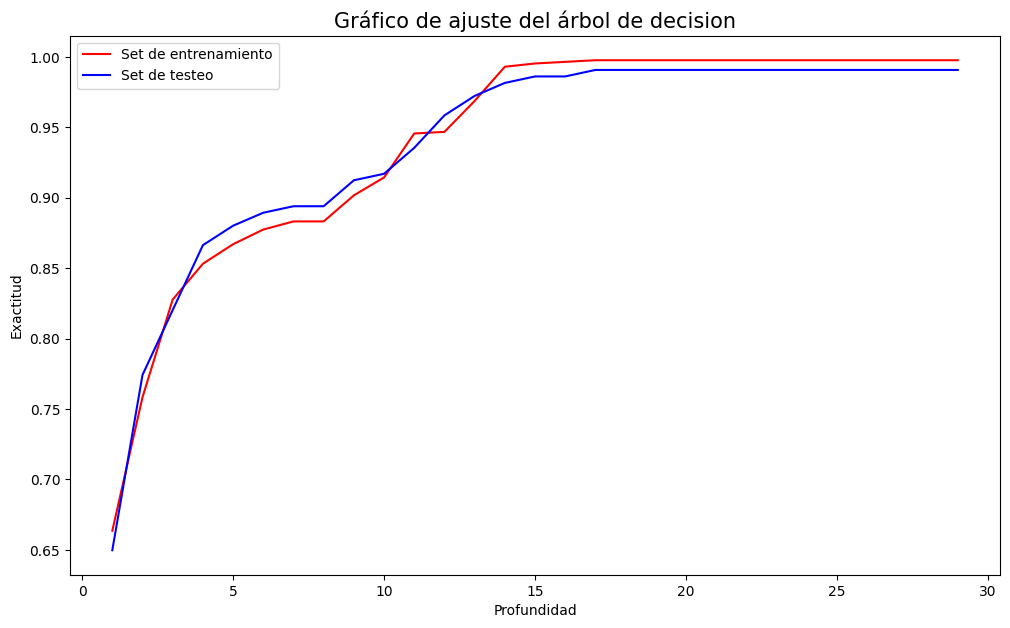

In [96]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

train_prec =  []
test_prec = []
max_deep_list = list(range(1, 30))

for deep in max_deep_list:
    clf_30 = DecisionTreeClassifier(max_depth=deep, criterion='entropy',random_state=234283)
    clf_30.fit(X_train, y_train)
    train_prec.append(clf_30.score(X_train, y_train))
    test_prec.append(clf_30.score(X_test, y_test))

plt.figure(figsize=(12,7))
plt.plot(max_deep_list, train_prec, color='r', label='Set de entrenamiento')
plt.plot(max_deep_list, test_prec, color='b', label='Set de testeo')
plt.title('Gráfico de ajuste del árbol de decision', fontsize = 15)
plt.legend()
plt.ylabel('Exactitud')
plt.xlabel('Profundidad')
plt.show()

Con estos resultados podemos encontrar que la mejor franja es donde el árbol de decisiones se encuentra que a partir de 14

### 8.3 Entrenamiento del Modelo Elegido

#### 8.3.1 Entrenamos el modelo

In [97]:
# Instanciamos el modelo
tree_model = DecisionTreeClassifier(max_depth = 15, criterion='entropy',random_state=234283)

#Entrenamos el modelo con la partición de train
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=15, random_state=234283)

#### 8.3.2 Creamos la predicción con el modelo

In [98]:
# Predecimos sobre nuestro set de entrenamiento
y_train_pred = tree_model.predict(X_train)

# Predecimos sobre nuestro set de test
y_test_pred = tree_model.predict(X_test)

# Comparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_train_pred,y_train))
print('Accuracy sobre conjunto de Test:', accuracy_score(y_test_pred,y_test))

Accuracy sobre conjunto de Train: 0.9953757225433526
Accuracy sobre conjunto de Test: 0.9861751152073732


#### 8.3.3 Matriz de confusión

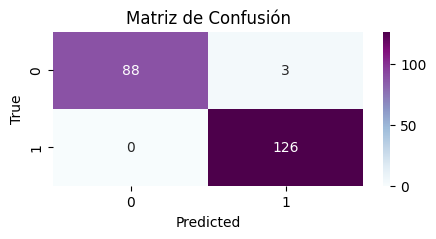

In [99]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(5,2))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='BuPu')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Matriz de Confusión")
plt.show()

#### 8.3.4 Métricas del modelo

In [100]:
# Comparamos con las etiquetas reales
from sklearn.metrics import classification_report

report = classification_report(y_test, y_test_pred)
print("Reporte de Clasificación:")
print(report)

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        91
           1       0.98      1.00      0.99       126

    accuracy                           0.99       217
   macro avg       0.99      0.98      0.99       217
weighted avg       0.99      0.99      0.99       217



#### 8.3.5 diagram de árbol 
Vemos el diagrama de toma de decisiones

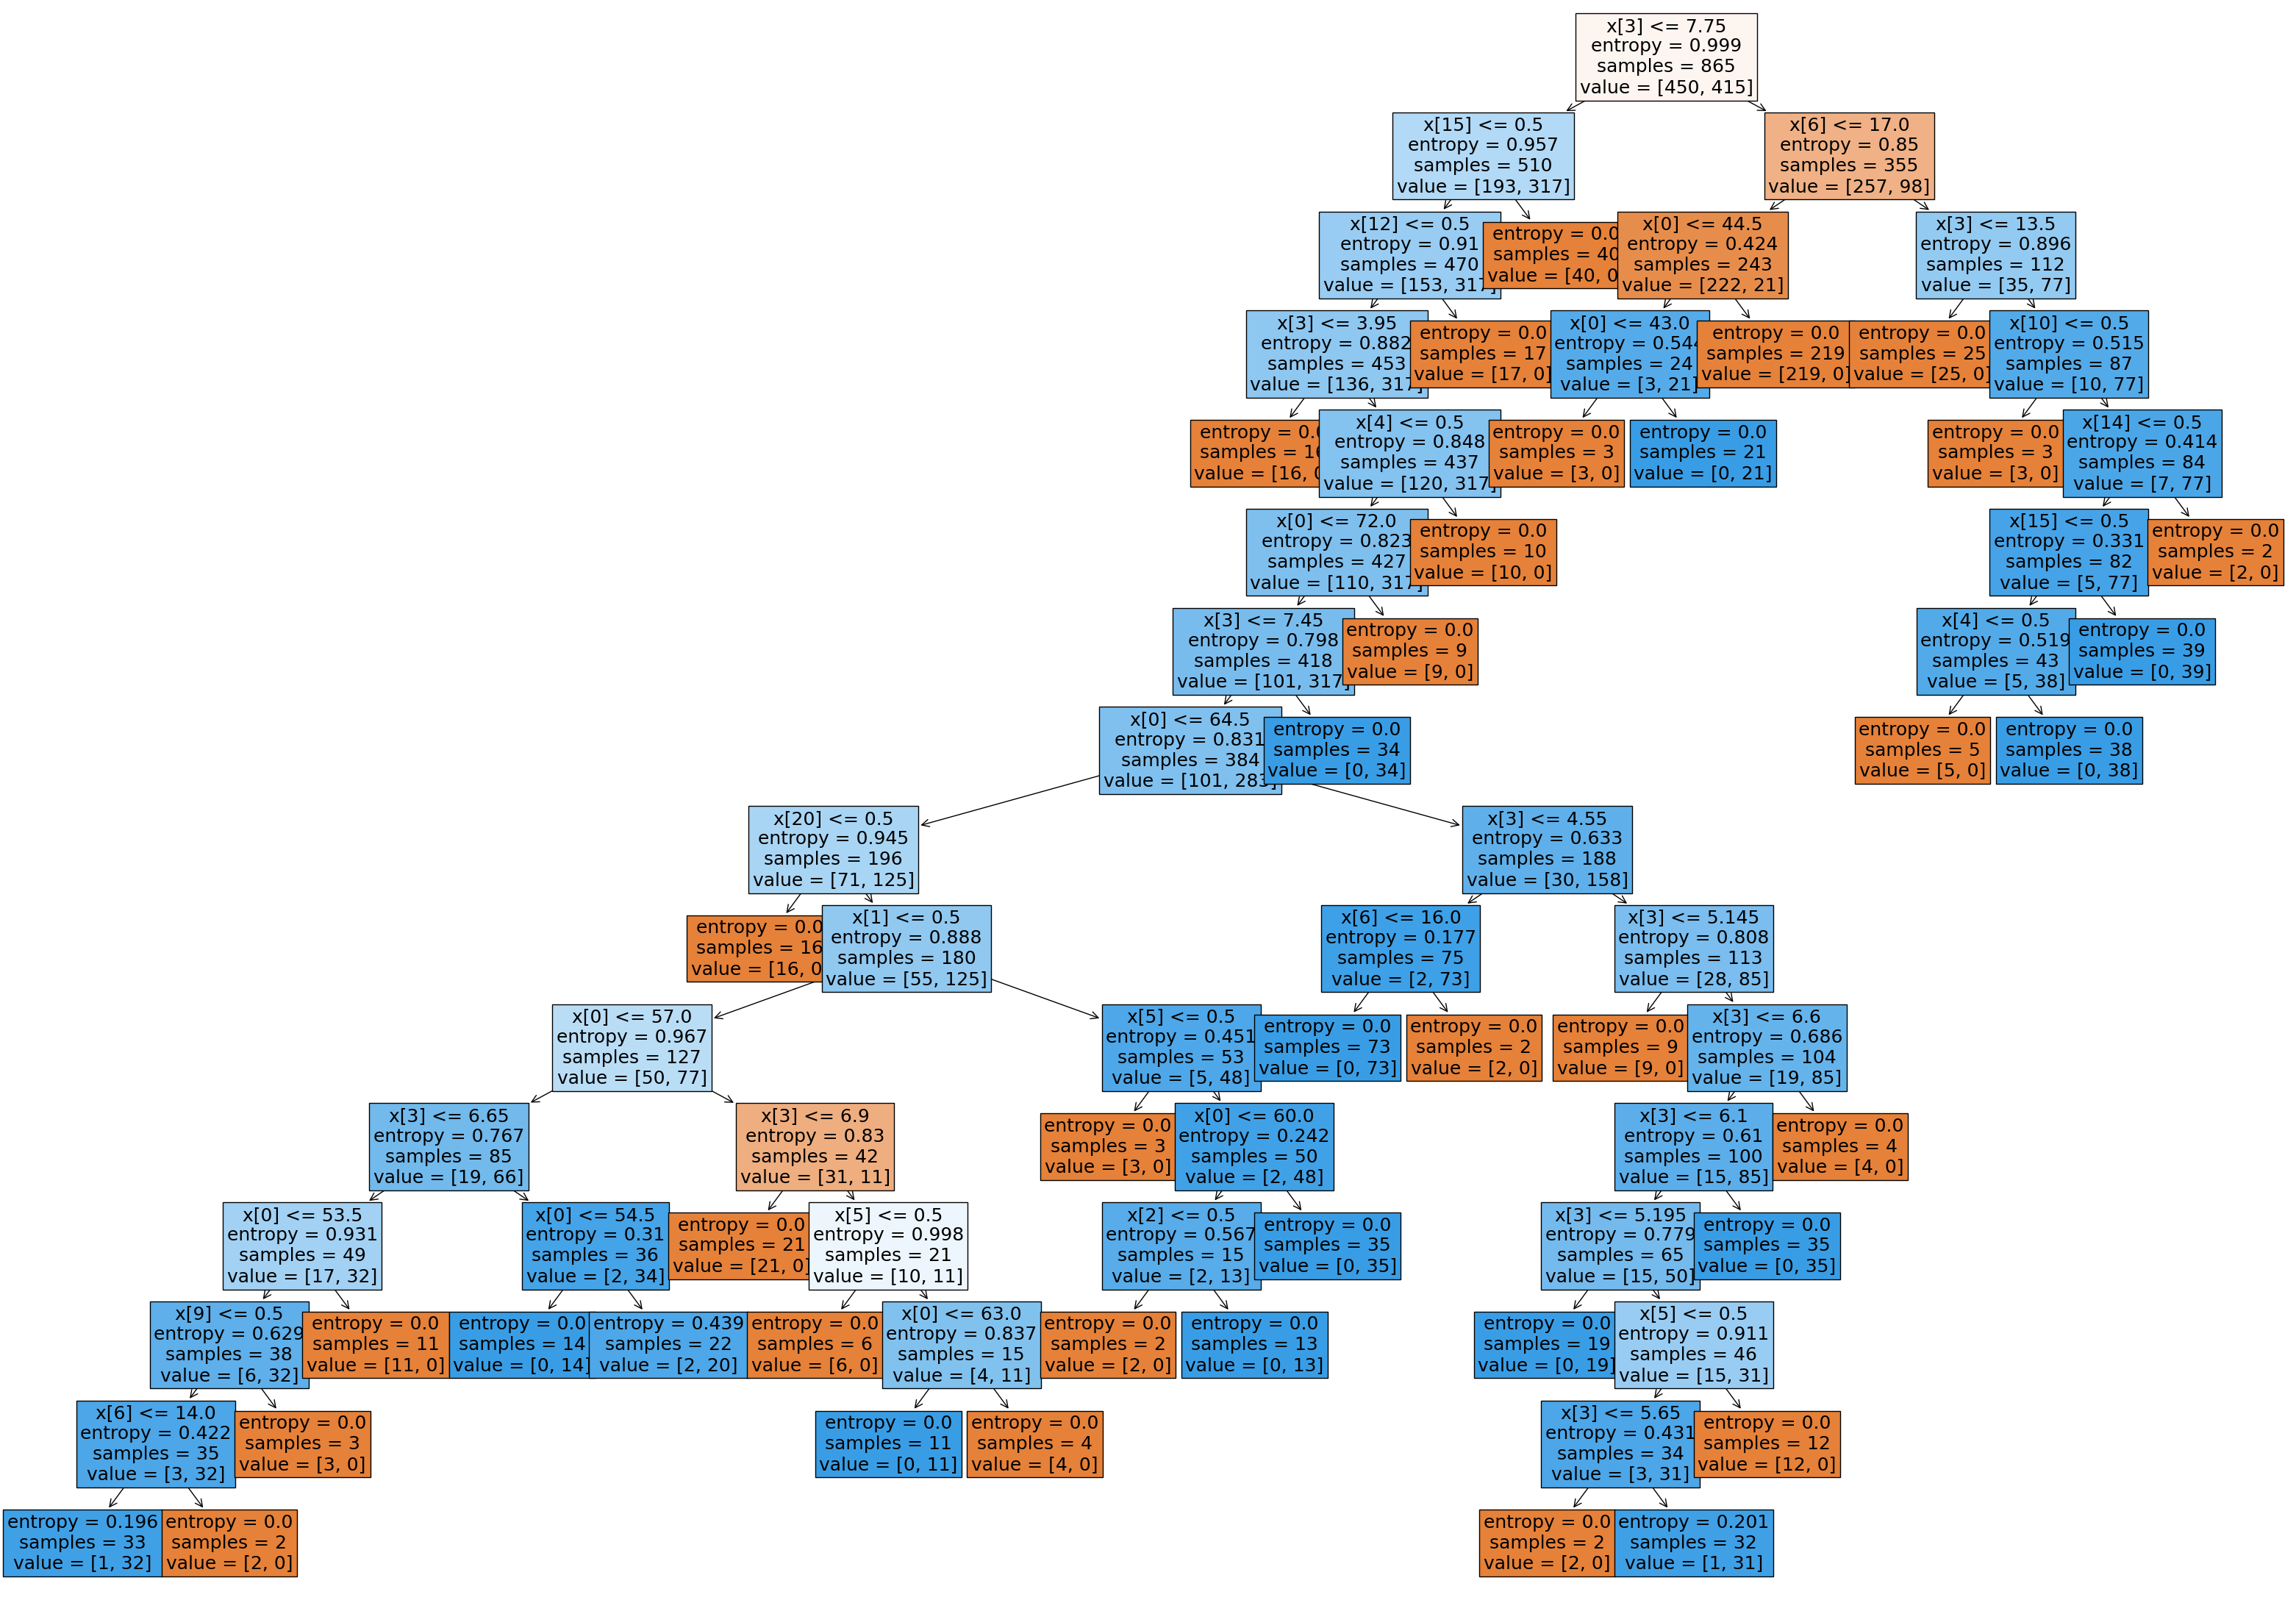

In [101]:
from sklearn import tree


plt.figure(figsize = (40,28))
tree.plot_tree(tree_model, filled = True,fontsize=18)

plt.show()

## 9. Modelo K Neighbors

### 9.1 Selección de valores óptimos de Hiperparámetros.  

In [102]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# parámetros a testear en el modelo
param_g = {'n_neighbors':np.arange(1, 20),
              'weights': ['uniform', 'distance'],
              'leaf_size':[1,3,5,7,9],
              'algorithm':['auto', 'kd_tree']}

# Instanciamos el modelo
knn = KNeighborsClassifier()

# Realizamos la búsqueda de los mejores hiperparámetros con validación cruzada y k-fold

grid=GridSearchCV(estimator=knn, param_grid=param_g,cv=5) 
# cv: número de folds para validar el modelo

# Scores del modelo
scores = cross_val_score(grid, X_train, y_train, scoring='accuracy')  
print("Accuracy scores:", scores)


Accuracy scores: [0.97687861 0.98265896 0.97687861 0.98843931 0.97687861]


#### 9.1.1 Entrenamos para encontrar los mejores parametros

In [103]:
# Entrenamos
grid.fit(X_train, y_train)

# imprimimos los mejores parámetros del gridsearch
print("Mejores hiperparámetros: "+str(grid.best_params_))
print("Mejor Score: "+str(grid.best_score_)+'\n')

Mejores hiperparámetros: {'algorithm': 'kd_tree', 'leaf_size': 1, 'n_neighbors': 2, 'weights': 'uniform'}
Mejor Score: 0.9815028901734104



#### 9.1.2 mostramos el dataframe de los resultados del gridsearch

In [104]:
scores = pd.DataFrame(grid.cv_results_)
# display(scores.head(3))
display(scores.tail(3))

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
377       0.004000  5.519789e-07         0.003000    2.780415e-07   
378       0.004196  4.021855e-04         0.010602    4.910527e-04   
379       0.003798  4.000427e-04         0.003202    4.005917e-04   

    param_algorithm param_leaf_size param_n_neighbors param_weights  \
377         kd_tree               9                18      distance   
378         kd_tree               9                19       uniform   
379         kd_tree               9                19      distance   

                                                params  split0_test_score  \
377  {'algorithm': 'kd_tree', 'leaf_size': 9, 'n_ne...           0.872832   
378  {'algorithm': 'kd_tree', 'leaf_size': 9, 'n_ne...           0.791908   
379  {'algorithm': 'kd_tree', 'leaf_size': 9, 'n_ne...           0.872832   

     split1_test_score  split2_test_score  split3_test_score  \
377           0.907514           0.913295           0.930636   
378           0.820809           0.809249           0.861272   
379           0.895954           0.919075           0.924855   

     split4_test_score  mean_test_score  std_test_score  rank_test_score  
377           0.919075         0.908671        0.019482              251  
378           0.872832         0.831214        0.030891              371  
379           0.913295         0.905202        0.018855              261

### 9.2 Predicción 

In [105]:
#Predecimos en los datos de test con el mejor modelo obtenido
prediction = grid.predict(X_test)

### 9.3 Matriz de confusion

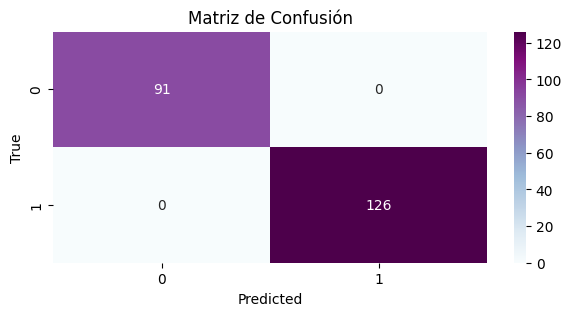

In [106]:
from sklearn.metrics import confusion_matrix, accuracy_score

cm = confusion_matrix(y_test,prediction)

plt.figure(figsize=(7,3))
sns.heatmap(cm, annot=True, fmt="d", cmap='BuPu')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Matriz de Confusión")
plt.show()


### 9.4 Resultados del modelo

In [107]:
from sklearn.metrics import classification_report

report = classification_report(y_test, prediction)
print("Reporte de Clasificación:")
print(report)

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        91
           1       1.00      1.00      1.00       126

    accuracy                           1.00       217
   macro avg       1.00      1.00      1.00       217
weighted avg       1.00      1.00      1.00       217



## 9. Conclusiones 

En este proyecto, hemos abordado el análisis y modelado de un conjunto de datos relacionados con pacientes sometidos a biopsias prostáticas y la posterior identificación de aquellos que presentan complicaciones infecciosas que requieren hospitalización. Aquí presentamos algunas conclusiones clave:

**Identificación de Casos y Controles:** Se definieron casos sin contar con la información de las complicaciones infecciosas posteriores, para asi desde el proceso de biopsia predecir los pacientes con mas probabilidades de presentar complicaciones.

**Preparación de Datos:** Se realizó una limpieza inicial de los datos y se generó una partición adecuada entre los conjuntos de entrenamiento y prueba. Además, se observó que existe un desbalance entre las clases objetivo, con más casos de no hospitalización que de  hospitalización, por lo que se requirió balancear el dataframe para generar un modelo mas preciso

**Modelado con Árbol de Decisión:** Se entrenó un modelo de árbol de decisión para predecir la hospitalización. El modelo logró una alta precisión apartir de una profundidad de 14, en los conjuntos de entrenamiento y prueba, lo que sugiere una buena capacidad de generalización.

**Análisis de Resultados:** Se presentaron matrices de confusión y un informe de clasificación para evaluar el rendimiento del modelo. Se logró una alta precisión y recall para ambas clases, lo que indica que el modelo es efectivo tanto en la identificación de casos como en la predicción de controles, llegando a un 98% de efectividad con solo 0.2% de varianza.

**Modelado con K-Vecinos más Cercanos (KNN):** Se exploró el modelo KNN para comparar su rendimiento con el modelo de árbol de decisión. Se llevaron a cabo búsquedas de hiperparámetros para optimizar el modelo KNN.

**Resultados y Rendimiento:** Ambos modelos, tanto el árbol de decisión como el KNN, demostraron un rendimiento excelente en la clasificación de pacientes con complicaciones infecciosas. Sin embargo, es importante considerar el equilibrio entre precisión y recall según las necesidades clínicas específicas.

## 10. Licencia
Este repositorio puede ser utilizado como referencia para futuros análisis de datos similares o como base para la implementación de modelos de machine learning en el contexto médico.

Siéntete libre de utilizar, modificar y compartir este código de acuerdo a tus necesidades. Recuerda que este análisis y los modelos generados son específicos para el conjunto de datos proporcionado y deben ser adaptados a otras situaciones clínicas o conjuntos de datos.

Este proyecto fue llevado a cabo por Octavio Rodriguez, y está disponible en el siguiente enlace :Repositorio: https://github.com/OctavioRdz17/Hospitales-ML.